In [1]:
import pandas as pd
import numpy as np
import math
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt

In [2]:
base_dir = "Data/"

label2one = {'B':0,'S':1,'X':2}
one2label = {0:'B', 1:'S', 2:'X'}

def normalize(data):
    mu = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    return mu, std, (data-mu)/std

vfunc = np.vectorize(lambda x:label2one[x])

input_labels = ['pitcher','batter','balls', 'strikes','inning','pitch_count']

feature_length = len(input_labels)-2
print("Feature length:{}".format(feature_length))
train_years = [4,5,6]
dev_years = [7]


train_x = {}
train_y = {}
ctr = 0
for y in train_years:
    filename= base_dir+"MLB_201{0}/MLB_PitchFX_201{0}_RegularSeason.csv".format(str(y))
    print("Loading {}".format(filename))
    f = pd.read_csv(filename)
    
    tmp_x = f[input_labels]
    tmp_y = f['umpcall']

    tmp_x = tmp_x.as_matrix()
    tmp_y = tmp_y.as_matrix()
    tmp_y = vfunc(tmp_y)

    if ctr==0:
        ctr=1
        train_x = tmp_x
        train_y = tmp_y
    else:
        print(train_x.shape)
        print(tmp_x.shape)
        train_x = np.concatenate((train_x, tmp_x), axis=0)
        train_y = np.concatenate((train_y, tmp_y), axis=0)
    
    filename= base_dir+"MLB_201{0}/MLB_PitchFX_201{0}_PostSeason.csv".format(str(y))
    print("Loading {}".format(filename))
    f = pd.read_csv(filename)
    
    tmp_x = f[input_labels]
    tmp_y = f['umpcall']

    tmp_x = tmp_x.as_matrix()
    tmp_y = tmp_y.as_matrix()
    tmp_y = vfunc(tmp_y)
    if ctr==0:
        ctr=1
        train_x = tmp_x
        train_y = tmp_y
    else:
        print(train_x.shape)
        print(tmp_x.shape)
        train_x = np.concatenate((train_x, tmp_x), axis=0)
        train_y = np.concatenate((train_y, tmp_y), axis=0)

filename = base_dir+"MLB_2017/MLB_PitchFX_2017_RegularSeason.csv"
print("Loading test file {}".format(filename))
f2 = pd.read_csv(filename)
test_x = f2[input_labels]
test_y = f2['umpcall']

test_x = test_x.as_matrix()
test_y = test_y.as_matrix()
test_y = vfunc(test_y)

filename = base_dir+"MLB_2017/MLB_PitchFX_2017_PostSeason.csv"
print("Loading test file {}".format(filename))
f2 = pd.read_csv(filename)

tmp_x = f2[input_labels]
tmp_y = f2['umpcall']

tmp_x = tmp_x.as_matrix()
tmp_y = tmp_y.as_matrix()
tmp_y = vfunc(tmp_y)

test_x = np.concatenate((test_x, tmp_x), axis=0)
test_y = np.concatenate((test_y, tmp_y), axis=0)

Feature length:4
Loading Data/MLB_2014/MLB_PitchFX_2014_RegularSeason.csv
Loading Data/MLB_2014/MLB_PitchFX_2014_PostSeason.csv
(658428, 6)
(8837, 6)
Loading Data/MLB_2015/MLB_PitchFX_2015_RegularSeason.csv
(667265, 6)
(672271, 6)
Loading Data/MLB_2015/MLB_PitchFX_2015_PostSeason.csv
(1339536, 6)
(10277, 6)
Loading Data/MLB_2016/MLB_PitchFX_2016_RegularSeason.csv
(1349813, 6)
(703809, 6)
Loading Data/MLB_2016/MLB_PitchFX_2016_PostSeason.csv
(2053622, 6)
(10076, 6)
Loading test file Data/MLB_2017/MLB_PitchFX_2017_RegularSeason.csv
Loading test file Data/MLB_2017/MLB_PitchFX_2017_PostSeason.csv


In [3]:
vv = np.vectorize(lambda x: (isinstance(x, float) and math.isnan(x) ))
idx = ~np.logical_or(vv(train_x[:,0]), vv(train_x[:,1]))
train_x = train_x[idx]
train_y = train_y[idx]

In [4]:
from sklearn.model_selection import train_test_split
train_x, dev_x, train_y, dev_y = train_test_split(train_x, train_y, test_size=0.1, random_state=0, shuffle=True)

In [5]:
train_x[0,:]

array(['conlead01', 'duvalad01', 0, 1, 4, 56], dtype=object)

In [6]:
class Lang:
    def __init__(self, name):
        """Init Lang with a name."""
        self.name = name
        self.word2index = {"<UNK>": 0}
        self.word2count = {}
        self.index2word = {0: "<UNK>"}
        self.n_words = 1  # Count SOS and EOS

    def addword(self, word):
        """Add a word to the dict."""
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [7]:
def map2idx(train_x, pl, bl):
    pi = train_x[:,0]
    vfnc = np.vectorize(lambda x: pl.word2index[x] if x in pitch_lang.word2index else 0)
    pi = vfnc(pi).reshape(-1,1)
    vfnc = np.vectorize(lambda x:bl.word2index[x] if x in batter_lang.word2index else 0)
    ba = vfnc(train_x[:,1]).reshape(-1,1)
    
    return np.concatenate((pi,ba,train_x[:,2:]), axis=1)

def data_gen(dx, df, dy, batch_size=100):
    idx = 0
    while True:
        if idx*batch_size >= dx.shape[0]:
            return
        elif (idx+1)*batch_size > dx.shape[0]:
            yield dx[idx*batch_size:,:], df[idx*batch_size:,:], dy[idx*batch_size:]
        else:
            yield dx[idx*batch_size:(idx+1)*batch_size,:], df[idx*batch_size:(idx+1)*batch_size], dy[idx*batch_size:(idx+1)*batch_size]
        idx += 1


def train(train_x, train_f, train_y, dev_x, dev_f, dev_y, model, scheduler, optimizer, criterion, batch_size=512, max_epoch = 512, validation_interv=1000):
    for ep in range(max_epoch):
        scheduler.step()
        print("Epoch {}".format(ep))
        train_iter = data_gen(train_x, train_f, train_y, batch_size=batch_size)
        ctr = 0
        avg_loss = 0
        for bx,bf,by in train_iter:
            optimizer.zero_grad()
            model.train()
            y_pred = model(bx,bf)
            loss = criterion(y_pred, by)
            loss.backward()
            avg_loss += loss.item()*bx.shape[0]
            optimizer.step()
            ctr+= bx.shape[0]
        #dy_pred = model(dev_x, dev_f)
        model.eval()
        ll = 0
        ctrr = 0
        acc = 0
        for dx,df,dy in data_gen(dev_x, dev_f, dev_y, batch_size=batch_size):
            dy_pred = model(dx, df)
            tmp = criterion(dy_pred, dy).item()
            ll += tmp * dx.shape[0]
            ctrr += dx.shape[0]
            mv, mi = torch.max(dy_pred, 1)
            acc += torch.sum( mi == dy ).item()
        
        print("loss:{} dev_loss:{}, dev_acc:{}".format(avg_loss/ctr, ll/ctrr, acc / ctrr))


In [8]:
pitch_lang = Lang('pitcher')
batter_lang = Lang('batter')
player_lang = Lang('player')
pits = train_x[:,0]
bats = train_x[:,1]
for i in range(len(train_x)):
    pitch_lang.addword(pits[i])
    batter_lang.addword(bats[i])
    player_lang.addword(pits[i])    
    player_lang.addword(bats[i])

In [9]:
DEVICE = torch.device('cuda')

In [10]:

vtx = Variable(torch.from_numpy(map2idx(train_x[:,:2], pitch_lang, batter_lang).astype(np.long))).to(DEVICE)
vtf = Variable(torch.from_numpy(train_x[:,2:].astype(np.long))).to(DEVICE)
vty = Variable(torch.from_numpy(train_y)).to(DEVICE)
vdx = Variable(torch.from_numpy(map2idx(dev_x[:,:2], pitch_lang, batter_lang).astype(np.long))).to(DEVICE)
vdf = Variable(torch.from_numpy(dev_x[:,2:].astype(np.long))).to(DEVICE)
vdy = Variable(torch.from_numpy(dev_y)).to(DEVICE)

vtestx = Variable(torch.from_numpy(map2idx(test_x[:,:2], pitch_lang, batter_lang).astype(np.long))).to(DEVICE)
vtestf = Variable(torch.from_numpy(test_x[:,2:].astype(np.long))).to(DEVICE)
vtesty = Variable(torch.from_numpy(test_y)).to(DEVICE)


# Model 2

In [11]:
class PlayerEmbedding(nn.Module):
    """The class for embedding records.
    This class is for embedding the docvec (r.t, r.e, r.m)
    into a high dimension space.
    Attributes:
        embedding1: embedding for r.t
        embedding2: embedding for r.e
        linear: A linear layer mapping [r.t, r.e, r.m] back to one space
    """

    def __init__(self, pitcher_size, batter_size, embedding_dim):
        super(PlayerEmbedding, self).__init__()
        self.embedding1 = nn.Embedding(pitcher_size, embedding_dim)
        self.embedding2 = nn.Embedding(batter_size, embedding_dim)
        self.embedding_dim = embedding_dim

    def forward(self, p, b):
        emb_p = self.embedding1(p)
        emb_b = self.embedding2(b)

        emb_all = torch.cat([emb_p, emb_b], dim=1)
        return emb_all

    def init_weights(self):
        initrange = 0.1
        em_layer = [self.embedding1, self.embedding2]

        for layer in em_layer:
            layer.weight.data.normal_(0, initrange)

class Fcc(nn.Module):
    def __init__(self, embedding_layer):
        super(Fcc, self).__init__()
        p=0.1
        self.embedding = embedding_layer
        self.drop_emb = nn.Dropout(p)
        self.drop1 = nn.Dropout(p)
        self.drop2 = nn.Dropout(p)
        self.drop3 = nn.Dropout(p)
        self.drop4 = nn.Dropout(p)
        self.lin1 = nn.Linear(2*self.embedding.embedding_dim + 8, 100)
        self.act1 = nn.SELU()
        self.lin2 = nn.Linear(100, 100)
        self.act2 = nn.SELU()
        self.lin3 = nn.Linear(100, 100)
        
        self.act3 = nn.SELU()
        self.lin4 = nn.Linear(100, 100)
        self.act4 = nn.SELU()
        self.lin5 = nn.Linear(100, 3)
        
        self.emb_balls = nn.Embedding(10 , 2)
        self.emb_strikes = nn.Embedding(10 , 2)
        self.emb_inning = nn.Embedding(20 , 2)
        self.emb_pitctr = nn.Embedding(500 , 2)
        #self.lin4 = nn.Linear(100, 3)

    def forward(self, players, features):
        embedded = self.embedding(players[:,0], players[:,1])
        eb_ball = self.emb_balls(features[:,0])
        eb_st = self.emb_strikes(features[:,1])
        eb_inning = self.emb_inning(features[:,2])
        eb_pit = self.emb_pitctr(features[:,3])
        output = torch.cat([embedded, eb_ball, eb_st, eb_inning, eb_pit], dim=1)
        output = self.drop_emb(output)
        
        output = self.lin1(output)
        output = self.act1(output)
        output = self.drop1(output)
        
        output = self.lin2(output)
        output = self.act2(output)
        output = self.drop2(output)
        
        output = self.lin3(output)
        output = self.act3(output)
        output = self.drop3(output)
        
        output = self.lin4(output)
        output = self.act4(output)
        output = self.drop4(output)
        
        output = self.lin5(output)
        
        output = F.log_softmax(output, dim=1)
        return output

In [12]:
emb_layer = PlayerEmbedding(pitch_lang.n_words,batter_lang.n_words, 5).to(DEVICE)
model = Fcc(emb_layer).to(DEVICE)
print(model)

Fcc(
  (embedding): PlayerEmbedding(
    (embedding1): Embedding(1073, 5)
    (embedding2): Embedding(1409, 5)
  )
  (drop_emb): Dropout(p=0.1)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.1)
  (drop3): Dropout(p=0.1)
  (drop4): Dropout(p=0.1)
  (lin1): Linear(in_features=18, out_features=100, bias=True)
  (act1): SELU()
  (lin2): Linear(in_features=100, out_features=100, bias=True)
  (act2): SELU()
  (lin3): Linear(in_features=100, out_features=100, bias=True)
  (act3): SELU()
  (lin4): Linear(in_features=100, out_features=100, bias=True)
  (act4): SELU()
  (lin5): Linear(in_features=100, out_features=3, bias=True)
  (emb_balls): Embedding(10, 2)
  (emb_strikes): Embedding(10, 2)
  (emb_inning): Embedding(20, 2)
  (emb_pitctr): Embedding(500, 2)
)


In [13]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
max_epoch = 100
#opt = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=max_epoch, eta_min=0)
crit = nn.NLLLoss()
train(vtx, vtf, vty, vdx, vdf, vdy, model, sched, opt, crit, max_epoch=max_epoch, batch_size=4096*16)

Epoch 0
loss:1.0426238298449 dev_loss:1.0287199401806946, dev_acc:0.4599118088869506
Epoch 1
loss:1.0327750097925543 dev_loss:1.0273150538430054, dev_acc:0.45992150021805495
Epoch 2
loss:1.0311245109329175 dev_loss:1.0250814885751633, dev_acc:0.4603139991277802
Epoch 3
loss:1.0292050736906933 dev_loss:1.0231527961605353, dev_acc:0.46059989339535784
Epoch 4
loss:1.0282576807291857 dev_loss:1.0227752752450108, dev_acc:0.46309056548916994
Epoch 5
loss:1.0276065659576616 dev_loss:1.0224042395123933, dev_acc:0.46434074720162816
Epoch 6
loss:1.027047086833935 dev_loss:1.0221304063274341, dev_acc:0.46510151669331784
Epoch 7
loss:1.026745286985251 dev_loss:1.0219342337772066, dev_acc:0.46513543635218296
Epoch 8
loss:1.0264445426465456 dev_loss:1.021687105194499, dev_acc:0.4652565779909871
Epoch 9
loss:1.025993288874202 dev_loss:1.0215272646816327, dev_acc:0.46527111498764356
Epoch 10
loss:1.0258496463107274 dev_loss:1.0214104619548148, dev_acc:0.46508213403110915
Epoch 11
loss:1.02571755942748

loss:1.018556183459873 dev_loss:1.0155784477852294, dev_acc:0.4696952076367689
Epoch 94
loss:1.0185007809510265 dev_loss:1.0155835561848903, dev_acc:0.4696176769879343
Epoch 95
loss:1.0184733253283493 dev_loss:1.0155828014561308, dev_acc:0.4696419053156951
Epoch 96
loss:1.018521652545122 dev_loss:1.0155832927680013, dev_acc:0.4696031399912778
Epoch 97
loss:1.0184646138406903 dev_loss:1.0155822480794112, dev_acc:0.46956922033241266
Epoch 98
loss:1.0185200575223017 dev_loss:1.0155806838481205, dev_acc:0.4695740659979648
Epoch 99
loss:1.018481591972901 dev_loss:1.0155805098650592, dev_acc:0.4695740659979648


In [14]:
print(model)
train(vtx, vtf, vty, vdx, vdf, vdy, model, sched, opt, crit, max_epoch=1000, batch_size=4096*16)

Fcc(
  (embedding): PlayerEmbedding(
    (embedding1): Embedding(1073, 5)
    (embedding2): Embedding(1409, 5)
  )
  (drop_emb): Dropout(p=0.1)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.1)
  (drop3): Dropout(p=0.1)
  (drop4): Dropout(p=0.1)
  (lin1): Linear(in_features=18, out_features=100, bias=True)
  (act1): SELU()
  (lin2): Linear(in_features=100, out_features=100, bias=True)
  (act2): SELU()
  (lin3): Linear(in_features=100, out_features=100, bias=True)
  (act3): SELU()
  (lin4): Linear(in_features=100, out_features=100, bias=True)
  (act4): SELU()
  (lin5): Linear(in_features=100, out_features=3, bias=True)
  (emb_balls): Embedding(10, 2)
  (emb_strikes): Embedding(10, 2)
  (emb_inning): Embedding(20, 2)
  (emb_pitctr): Embedding(500, 2)
)
Epoch 0
loss:1.0184985879470194 dev_loss:1.0155805098650592, dev_acc:0.4695740659979648
Epoch 1
loss:1.0184519601231965 dev_loss:1.015580498587053, dev_acc:0.469578911663517
Epoch 2
loss:1.0185105323834636 dev_loss:1.0155795416802162, de

loss:1.0155218932418377 dev_loss:1.0132467364816637, dev_acc:0.4710956049813442
Epoch 85
loss:1.015290706696392 dev_loss:1.0131042720793568, dev_acc:0.4712942772689829
Epoch 86
loss:1.0153025315672013 dev_loss:1.0131013616374362, dev_acc:0.471386344914474
Epoch 87
loss:1.0152229801448447 dev_loss:1.0130743962015392, dev_acc:0.47135242525560883
Epoch 88
loss:1.0151036957670896 dev_loss:1.0129327354455644, dev_acc:0.47138149924892186
Epoch 89
loss:1.015121165205923 dev_loss:1.0130621005867597, dev_acc:0.4715656345399041
Epoch 90
loss:1.015010093271275 dev_loss:1.012840065758791, dev_acc:0.4715317148810389
Epoch 91
loss:1.0148975540189 dev_loss:1.0127788809350093, dev_acc:0.47158017153656057
Epoch 92
loss:1.0148772568296978 dev_loss:1.0127274042160848, dev_acc:0.47172554150312546
Epoch 93
loss:1.0148088079827977 dev_loss:1.0128101631924644, dev_acc:0.4717643068275428
Epoch 94
loss:1.0147471577325744 dev_loss:1.0126017364298252, dev_acc:0.47158017153656057
Epoch 95
loss:1.0146603692055742 

loss:1.0123272094853655 dev_loss:1.0109190660235365, dev_acc:0.47298541454668797
Epoch 177
loss:1.0122273609497996 dev_loss:1.0109002414077568, dev_acc:0.47299995154334445
Epoch 178
loss:1.0122814878680042 dev_loss:1.0108881090710593, dev_acc:0.4729951058777923
Epoch 179
loss:1.0123556824849742 dev_loss:1.010878706011897, dev_acc:0.47305325386441827
Epoch 180
loss:1.012297320279438 dev_loss:1.010861179589151, dev_acc:0.4729757232155837
Epoch 181
loss:1.0123260775644944 dev_loss:1.010870356262149, dev_acc:0.4728933469011969
Epoch 182
loss:1.0122981289941575 dev_loss:1.0108733598406234, dev_acc:0.4728642729078839
Epoch 183
loss:1.0122581179128463 dev_loss:1.0108413133740441, dev_acc:0.47302902553665743
Epoch 184
loss:1.0123180904250244 dev_loss:1.010833013009764, dev_acc:0.47293695789116635
Epoch 185
loss:1.0122095826459128 dev_loss:1.0108415831843451, dev_acc:0.47283519891457093
Epoch 186
loss:1.012299842048377 dev_loss:1.0108273054027637, dev_acc:0.4729078838978534
Epoch 187
loss:1.012

loss:1.0119847062320404 dev_loss:1.010844016335076, dev_acc:0.47283035324901873
Epoch 269
loss:1.0120621316135123 dev_loss:1.0108149465793914, dev_acc:0.4729175752289577
Epoch 270
loss:1.0119545936335956 dev_loss:1.0108224511279404, dev_acc:0.4728448902456752
Epoch 271
loss:1.0120189421781753 dev_loss:1.010770691090986, dev_acc:0.4726801376169017
Epoch 272
loss:1.0120240224750663 dev_loss:1.0108240042984205, dev_acc:0.473043562533314
Epoch 273
loss:1.0119894036580594 dev_loss:1.0107552778953648, dev_acc:0.4728400445801231
Epoch 274
loss:1.0120180540128463 dev_loss:1.0108605396264096, dev_acc:0.47285458157677956
Epoch 275
loss:1.0119965422296524 dev_loss:1.0108033055522538, dev_acc:0.47278674225904926
Epoch 276
loss:1.0119331051997433 dev_loss:1.0108316866332676, dev_acc:0.4729466492222707
Epoch 277
loss:1.011859148887363 dev_loss:1.0108337798876235, dev_acc:0.4729757232155837
Epoch 278
loss:1.0118547145581138 dev_loss:1.010808909472531, dev_acc:0.4726510636235887
Epoch 279
loss:1.01193

loss:1.0107011205729033 dev_loss:1.0102630705671, dev_acc:0.47335368512865245
Epoch 361
loss:1.0107890683207217 dev_loss:1.010274250451785, dev_acc:0.4733972961186219
Epoch 362
loss:1.0108283520593118 dev_loss:1.0102272700667294, dev_acc:0.4734360614430392
Epoch 363
loss:1.0107947457279616 dev_loss:1.0102763868795783, dev_acc:0.4733439937975481
Epoch 364
loss:1.0107671406415657 dev_loss:1.0102704805060922, dev_acc:0.4734118331152784
Epoch 365
loss:1.0107272429807312 dev_loss:1.0102169279512199, dev_acc:0.47340214178417406
Epoch 366
loss:1.0108239955591474 dev_loss:1.0102265881054877, dev_acc:0.4734360614430392
Epoch 367
loss:1.0107682235993698 dev_loss:1.0101991438199056, dev_acc:0.4734409071085914
Epoch 368
loss:1.0107628797754242 dev_loss:1.0101449612389992, dev_acc:0.47345544410524787
Epoch 369
loss:1.0108049458298525 dev_loss:1.0101111321646374, dev_acc:0.4735087464263217
Epoch 370
loss:1.0106823080966205 dev_loss:1.0101146280959046, dev_acc:0.4736395793962301
Epoch 371
loss:1.0106

loss:1.0105994174236912 dev_loss:1.0103290646772962, dev_acc:0.4735087464263217
Epoch 453
loss:1.0106932911475195 dev_loss:1.010261112939955, dev_acc:0.4733972961186219
Epoch 454
loss:1.010621481775107 dev_loss:1.0102689311145876, dev_acc:0.4735959684062606
Epoch 455
loss:1.0106285838310693 dev_loss:1.0102765030804755, dev_acc:0.47360081407181276
Epoch 456
loss:1.0106886292009567 dev_loss:1.0102341092868432, dev_acc:0.47362988806512574
Epoch 457
loss:1.0105885193308353 dev_loss:1.0102654415767323, dev_acc:0.4733924504530697
Epoch 458
loss:1.010539483590888 dev_loss:1.0102721588922494, dev_acc:0.47341667878083055
Epoch 459
loss:1.010635503254453 dev_loss:1.0102661794601107, dev_acc:0.4736638077239909
Epoch 460
loss:1.0106199486793368 dev_loss:1.0102528691447774, dev_acc:0.47358627707515627
Epoch 461
loss:1.010572620734693 dev_loss:1.0102304639029296, dev_acc:0.47381402335610795
Epoch 462
loss:1.010640142076572 dev_loss:1.0101798212192614, dev_acc:0.4737897950283471
Epoch 463
loss:1.0105

loss:1.0097927973425955 dev_loss:1.0100635218725433, dev_acc:0.47424044192469833
Epoch 544
loss:1.0097660662714394 dev_loss:1.0100654484753508, dev_acc:0.47409507195813344
Epoch 545
loss:1.0097832611036548 dev_loss:1.0100946126545898, dev_acc:0.4741289916169986
Epoch 546
loss:1.009748745914306 dev_loss:1.0101649883753825, dev_acc:0.4740756892959248
Epoch 547
loss:1.0098068975187833 dev_loss:1.0101628785979733, dev_acc:0.4736056597373649
Epoch 548
loss:1.0098593371659375 dev_loss:1.010189135028288, dev_acc:0.47369772738285604
Epoch 549
loss:1.0098481366848855 dev_loss:1.010102505286939, dev_acc:0.4739254736638077
Epoch 550
loss:1.0097242036428995 dev_loss:1.0100912238285686, dev_acc:0.4738382516838688
Epoch 551
loss:1.0097636985073102 dev_loss:1.0100397446673468, dev_acc:0.4739254736638077
Epoch 552
loss:1.0097643019682032 dev_loss:1.010068966602178, dev_acc:0.47414837427920725
Epoch 553
loss:1.0097147884648057 dev_loss:1.0100745082022857, dev_acc:0.47404661530261183
Epoch 554
loss:1.00

loss:1.0097442231344196 dev_loss:1.010002509093235, dev_acc:0.47388186267383825
Epoch 636
loss:1.0096458579593042 dev_loss:1.009964373687409, dev_acc:0.47378494936279497
Epoch 637
loss:1.0097093333718052 dev_loss:1.0099910124192641, dev_acc:0.4739836216504337
Epoch 638
loss:1.0095877227241148 dev_loss:1.010000954452062, dev_acc:0.47381886902166015
Epoch 639
loss:1.0095413208991613 dev_loss:1.0099863343791755, dev_acc:0.4740902262925813
Epoch 640
loss:1.0096476810102106 dev_loss:1.0100837439918158, dev_acc:0.47383340601831664
Epoch 641
loss:1.0096635296122467 dev_loss:1.010033889044889, dev_acc:0.4739545476571207
Epoch 642
loss:1.0096324914620047 dev_loss:1.0100391897818097, dev_acc:0.4739690846537772
Epoch 643
loss:1.0095629317340062 dev_loss:1.0101078483354458, dev_acc:0.4741047632892378
Epoch 644
loss:1.0096077195481759 dev_loss:1.010104578608961, dev_acc:0.47393031932935986
Epoch 645
loss:1.009622222512572 dev_loss:1.010152870978982, dev_acc:0.4738382516838688
Epoch 646
loss:1.00960

loss:1.0092168045688037 dev_loss:1.0099220705903442, dev_acc:0.4740369239715075
Epoch 727
loss:1.0093081801451713 dev_loss:1.0098641591218342, dev_acc:0.4741386829481029
Epoch 728
loss:1.0092424969459843 dev_loss:1.0099183452910923, dev_acc:0.47421621359693755
Epoch 729
loss:1.0090573162817822 dev_loss:1.0098319931190167, dev_acc:0.47404661530261183
Epoch 730
loss:1.0091637781504472 dev_loss:1.0098905805158092, dev_acc:0.4740853806270291
Epoch 731
loss:1.0091560016397627 dev_loss:1.0099084515670256, dev_acc:0.4742065222658332
Epoch 732
loss:1.0091782189505718 dev_loss:1.0099343747566298, dev_acc:0.4741047632892378
Epoch 733
loss:1.009224250486618 dev_loss:1.009938914118369, dev_acc:0.47411445462034213
Epoch 734
loss:1.0091764547212747 dev_loss:1.0099135814794662, dev_acc:0.4741435286136551
Epoch 735
loss:1.0090971941947238 dev_loss:1.0099425583539179, dev_acc:0.47423075059359404
Epoch 736
loss:1.0090814359102864 dev_loss:1.0098714475883106, dev_acc:0.47429374424577214
Epoch 737
loss:1.

loss:1.008805792157918 dev_loss:1.0097585783694705, dev_acc:0.474259824586907
Epoch 819
loss:1.00876825241294 dev_loss:1.0097452465032326, dev_acc:0.4740369239715075
Epoch 820
loss:1.0088159528461782 dev_loss:1.0097370588832015, dev_acc:0.47423075059359404
Epoch 821
loss:1.0088956338344286 dev_loss:1.0097329468992138, dev_acc:0.4741677569414159
Epoch 822
loss:1.0088155631092421 dev_loss:1.00972789093847, dev_acc:0.4740078499781945
Epoch 823
loss:1.0087487446085255 dev_loss:1.0097354184369878, dev_acc:0.47399815864709016
Epoch 824
loss:1.0089430789057448 dev_loss:1.0097370069479938, dev_acc:0.4739836216504337
Epoch 825
loss:1.0088915929390687 dev_loss:1.0097324186305572, dev_acc:0.47406599796482046
Epoch 826
loss:1.0088269412792252 dev_loss:1.0097189998802314, dev_acc:0.4740853806270291
Epoch 827
loss:1.0089837434605402 dev_loss:1.0097269025682831, dev_acc:0.4742549789213549
Epoch 828
loss:1.0088159801112095 dev_loss:1.0097477587363328, dev_acc:0.47409991762368564
Epoch 829
loss:1.00888

loss:1.0088028357905405 dev_loss:1.0098781598401623, dev_acc:0.4743906575568154
Epoch 911
loss:1.0088020490162126 dev_loss:1.0098875633984128, dev_acc:0.4741726026069681
Epoch 912
loss:1.008729604456885 dev_loss:1.0098869904833154, dev_acc:0.4743034355768765
Epoch 913
loss:1.0086939008828901 dev_loss:1.0098826594758694, dev_acc:0.47421621359693755
Epoch 914
loss:1.008763486512155 dev_loss:1.010009785608167, dev_acc:0.4747201628143626
Epoch 915
loss:1.0087403540133415 dev_loss:1.0099082198664968, dev_acc:0.47421621359693755
Epoch 916
loss:1.0086608088686173 dev_loss:1.0099711698461493, dev_acc:0.4744051945534719
Epoch 917
loss:1.0087927965893042 dev_loss:1.0099564393280538, dev_acc:0.4743567378979503
Epoch 918
loss:1.008805817856879 dev_loss:1.0099159347460518, dev_acc:0.4743906575568154
Epoch 919
loss:1.0087702271652488 dev_loss:1.0099028957117122, dev_acc:0.47446818820565007
Epoch 920
loss:1.0086777810605425 dev_loss:1.009900597583972, dev_acc:0.47424528759025053
Epoch 921
loss:1.0087

In [12]:
emb_layer = PlayerEmbedding(pitch_lang.n_words,batter_lang.n_words, 5).cuda()
emb_layer.load_state_dict(torch.load('shallow_post.pt.emb'))
model = Fcc(emb_layer).cuda()
model.load_state_dict(torch.load('shallow_post.pt.model'))

In [25]:
torch.save(model.state_dict(), 'shallow_post.pt.model')
torch.save(emb_layer.state_dict(), 'shallow_post.pt.emb')

In [18]:
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import pickle
import seaborn as sn
import matplotlib.pyplot as plt

def generate_confusion_matrix(y_test, y_train, file_name = "confusion_matrix.png"):
    ax= plt.subplot()
    cm = confusion_matrix(y_test, y_train)
    df_cm = pd.DataFrame(cm, range(3), range(3))
    sn.set(font_scale=1.2)#for label size
    sn.heatmap(df_cm, annot=True, fmt="d",annot_kws={"size": 14}, cmap="YlGnBu")
#     ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['Ball', 'Strike', 'Hit']) 
    ax.yaxis.set_ticklabels(['Ball', 'Strike', 'Hit'])
    #plt.savefig(file_name)
    plt.show()

### Loss

In [14]:
criter = nn.NLLLoss()
with torch.no_grad():
    ll=0
    ctrr=0
    crit=nn.NLLLoss()
    for dx,df,dy in data_gen(vtestx, vtestf, vtesty, batch_size=128):
        model.eval()
        dy_pred = model(dx, df)
        tmp = criter(dy_pred, dy).data[0]
        ll += tmp * dx.shape[0]
        ctrr += dx.shape[0]
    dev_loss = ll.item()/ctrr

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if __name__ == '__main__':


### Accuracy

In [15]:
with torch.no_grad():
    ll=0
    ctrr=0
    pred = []
    prob = []
    for dx,df,dy in data_gen(vtestx, vtestf, vtesty, batch_size=128):
        model.eval()
        dy_pred = model(dx, df)
        prob.append(dy_pred.cpu().data)
        _,py = torch.max(dy_pred, 1)
        ll += torch.sum(py==dy)
        pred.append(py.cpu().data)
        ctrr += dx.shape[0]
    dev_acc = ll.item()/ctrr

In [16]:
pred_y = torch.cat(pred).numpy()
prob_y = torch.cat(prob).numpy()

Fcc(
  (embedding): PlayerEmbedding(
    (embedding1): Embedding(1073, 5)
    (embedding2): Embedding(1409, 5)
  )
  (drop_emb): Dropout(p=0.1)
  (drop1): Dropout(p=0.1)
  (drop2): Dropout(p=0.1)
  (drop3): Dropout(p=0.1)
  (drop4): Dropout(p=0.1)
  (lin1): Linear(in_features=18, out_features=100, bias=True)
  (act1): SELU()
  (lin2): Linear(in_features=100, out_features=100, bias=True)
  (act2): SELU()
  (lin3): Linear(in_features=100, out_features=100, bias=True)
  (act3): SELU()
  (lin4): Linear(in_features=100, out_features=100, bias=True)
  (act4): SELU()
  (lin5): Linear(in_features=100, out_features=3, bias=True)
  (emb_balls): Embedding(10, 2)
  (emb_strikes): Embedding(10, 2)
  (emb_inning): Embedding(20, 2)
  (emb_pitctr): Embedding(500, 2)
)
test loss: 1.0161314429798007 dev_los: 0.4667620672574165


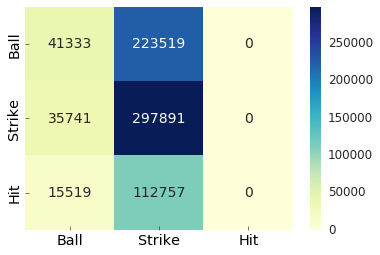

In [19]:
print(model)
print("test loss: {} dev_los: {}".format(dev_loss, dev_acc))
generate_confusion_matrix(test_y, pred_y)

In [36]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
y_test = label_binarize(test_y, classes=[0, 1, 2])
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], prob_y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [37]:
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), prob_y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

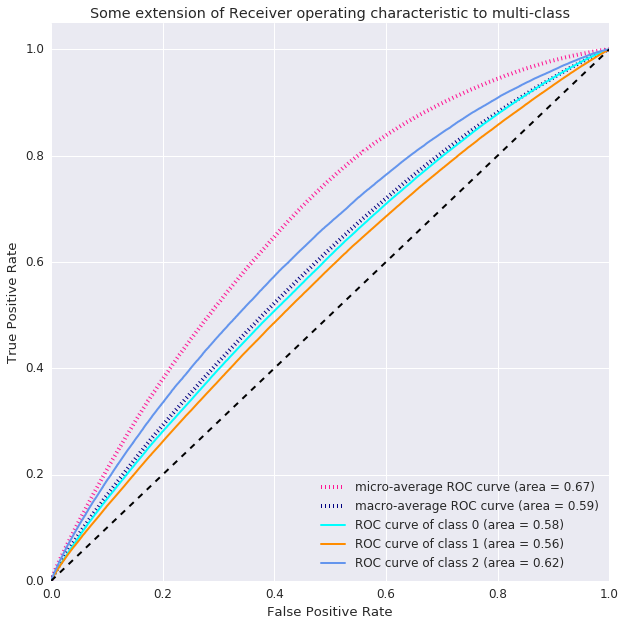

In [47]:
# Compute macro-average ROC curve and ROC area
lw=2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [51]:
from sklearn.metrics import f1_score
print("f1_macro: {}, f1_micro: {}".format(f1_score(test_y, pred_y, average='macro'), f1_score(test_y, pred_y, average='micro')))

f1_macro: 0.31262931749235384, f1_micro: 0.4710234465298035
